In [55]:
import numpy as np

import matplotlib as mpl
import matplotlib
# matplotlib.use('agg')
# matplotlib.use('TkAgg')
# matplotlib.use('qtagg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [56]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

from tqdm import tqdm  

In [57]:
def TB_reindex(TB_now):
    TB_now = TB_now.reset_index()
    TB_now = TB_now.drop(columns='index')
    return TB_now

In [58]:
def make_bins(wavs):
    """ Given a series of wavelength points, find the edges and widths
    of corresponding wavelength bins. """
    edges = np.zeros(wavs.shape[0]+1)
    widths = np.zeros(wavs.shape[0])
    edges[0] = wavs[0] - (wavs[1] - wavs[0])/2
    widths[-1] = (wavs[-1] - wavs[-2])
    edges[-1] = wavs[-1] + (wavs[-1] - wavs[-2])/2
    edges[1:-1] = (wavs[1:] + wavs[:-1])/2
    widths[:-1] = edges[1:-1] - edges[:-2]

    return edges, widths

In [59]:
def spectres(new_wavs, spec_wavs, spec_fluxes, spec_errs=None, fill=None,
             verbose=True):

    """
    Function for resampling spectra (and optionally associated
    uncertainties) onto a new wavelength basis.

    Parameters
    ----------

    new_wavs : numpy.ndarray
        Array containing the new wavelength sampling desired for the
        spectrum or spectra.

    spec_wavs : numpy.ndarray
        1D array containing the current wavelength sampling of the
        spectrum or spectra.

    spec_fluxes : numpy.ndarray
        Array containing spectral fluxes at the wavelengths specified in
        spec_wavs, last dimension must correspond to the shape of
        spec_wavs. Extra dimensions before this may be used to include
        multiple spectra.

    spec_errs : numpy.ndarray (optional)
        Array of the same shape as spec_fluxes containing uncertainties
        associated with each spectral flux value.

    fill : float (optional)
        Where new_wavs extends outside the wavelength range in spec_wavs
        this value will be used as a filler in new_fluxes and new_errs.

    verbose : bool (optional)
        Setting verbose to False will suppress the default warning about
        new_wavs extending outside spec_wavs and "fill" being used.

    Returns
    -------

    new_fluxes : numpy.ndarray
        Array of resampled flux values, first dimension is the same
        length as new_wavs, other dimensions are the same as
        spec_fluxes.

    new_errs : numpy.ndarray
        Array of uncertainties associated with fluxes in new_fluxes.
        Only returned if spec_errs was specified.
    """

    # Rename the input variables for clarity within the function.
    old_wavs = spec_wavs
    old_fluxes = spec_fluxes
    old_errs = spec_errs

    # Make arrays of edge positions and widths for the old and new bins

    old_edges, old_widths = make_bins(old_wavs)
    new_edges, new_widths = make_bins(new_wavs)

    # Generate output arrays to be populated
    new_fluxes = np.zeros(old_fluxes[..., 0].shape + new_wavs.shape)

    if old_errs is not None:
        if old_errs.shape != old_fluxes.shape:
            raise ValueError("If specified, spec_errs must be the same shape "
                             "as spec_fluxes.")
        else:
            new_errs = np.copy(new_fluxes)

    start = 0
    stop = 0

    # Calculate new flux and uncertainty values, looping over new bins
    for j in range(new_wavs.shape[0]):

        # Add filler values if new_wavs extends outside of spec_wavs
        if (new_edges[j] < old_edges[0]) or (new_edges[j+1] > old_edges[-1]):
            new_fluxes[..., j] = fill

            if spec_errs is not None:
                new_errs[..., j] = fill

            # if (j == 0 or j == new_wavs.shape[0]-1) and verbose:
            #     warnings.warn(
            #         "Spectres: new_wavs contains values outside the range "
            #         "in spec_wavs, new_fluxes and new_errs will be filled "
            #         "with the value set in the 'fill' keyword argument "
            #         "(by default 0).",
            #         category=RuntimeWarning,
            #     )
            continue

        # Find first old bin which is partially covered by the new bin
        while old_edges[start+1] <= new_edges[j]:
            start += 1

        # Find last old bin which is partially covered by the new bin
        while old_edges[stop+1] < new_edges[j+1]:
            stop += 1

        # If new bin is fully inside an old bin start and stop are equal
        if stop == start:
            new_fluxes[..., j] = old_fluxes[..., start]
            if old_errs is not None:
                new_errs[..., j] = old_errs[..., start]

        # Otherwise multiply the first and last old bin widths by P_ij
        else:
            start_factor = ((old_edges[start+1] - new_edges[j])
                            / (old_edges[start+1] - old_edges[start]))

            end_factor = ((new_edges[j+1] - old_edges[stop])
                          / (old_edges[stop+1] - old_edges[stop]))

            old_widths[start] *= start_factor
            old_widths[stop] *= end_factor

            # Populate new_fluxes spectrum and uncertainty arrays
            f_widths = old_widths[start:stop+1]*old_fluxes[..., start:stop+1]
            new_fluxes[..., j] = np.sum(f_widths, axis=-1)
            new_fluxes[..., j] /= np.sum(old_widths[start:stop+1])

            if old_errs is not None:
                e_wid = old_widths[start:stop+1]*old_errs[..., start:stop+1]

                new_errs[..., j] = np.sqrt(np.sum(e_wid**2, axis=-1))
                new_errs[..., j] /= np.sum(old_widths[start:stop+1])

            # Put back the old bin widths to their initial values
            old_widths[start] /= start_factor
            old_widths[stop] /= end_factor

    # If errors were supplied return both new_fluxes and new_errs.
    if old_errs is not None:
        return new_fluxes, new_errs

    # Otherwise just return the new_fluxes spectrum array
    else:
        return new_fluxes

# Global Setting

## Galaxy information

In [60]:
c = 299792.458  # spped of light [km/s]

galaxy_name = 'VCC_1588'
spectrum_filename = 'VCC1588_stack.fits'
spectrum_z = 0.0042

## basic fitting parameters

In [61]:
lam_range_temp = [4820, 5220]
redshift = spectrum_z           # redshift from
objfile = Path('./../Ori_Data/'+spectrum_filename)

In [62]:
# templates

sps_name = 'emiles'
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [63]:
# vel_s = c * spectrum_z
vel_s = 0
vel_dis_s = 40 # Set the dis v = 40 km/s

# Data Input

In [64]:
## Code from example

class read_data_cube:
    def __init__(self, filename, lam_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > lam_range[0]) & (wave < lam_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cubevar = self.cubevar[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cubevar, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize_x
        y = (row - row[jm])*self.pixsize_y

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)        # create array of spectra [npix, nx*ny]
        variance = cubevar.reshape(npix, -1)    # create array of variance [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)

        self.velfield = np.ndarray(shape=self.cube.shape[1:3])
        self.sigfield = np.ndarray(shape=self.cube.shape[1:3])

        # self.CD1_1 = self.CD1_1
        # self.CD1_2 = self.CD1_2
        # self.CD2_1 = self.CD2_1
        # self.CD2_2 = self.CD2_2
        # self.CRVAL1 = self.CRVAL1
        # self.CRVAL2 = self.CRVAL2

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """

        Cut_LHS = 1
        Cut_RHS = 1

        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:] * (10 ** 18)
        # cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:]
        # cube = hdu[0].data * (10 ** 18)
        cubevar = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0]) + head['CD3_3']*Cut_LHS

        self.cube = cube
        self.cubevar = cubevar
        self.wave = wave
        
        # self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.fwhm_gal = 1
        # self.pixsize = abs(head["CDELT1"])*3600    # 0.2"
        self.pixsize_x = abs(np.sqrt((head['CD1_1'])**2+(head['CD2_1'])**2))*3600
        self.pixsize_y = abs(np.sqrt((head['CD1_2'])**2+(head['CD2_2'])**2))*3600

        self.CD1_1 = head['CD1_1']
        self.CD1_2 = head['CD1_2']
        self.CD2_1 = head['CD2_1']
        self.CD2_2 = head['CD2_2']
        self.CRVAL1 = head['CRVAL1']
        self.CRVAL2 = head['CRVAL2']

In [65]:
Galaxy_info = read_data_cube(objfile, lam_range_temp, redshift)

# Devide Radius bin

## Parameters pre-set

In [66]:
FWHM_gal = None   # set this to None to skip templates broadening
sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal, norm_range=[4827.875, 5206.375])
# sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal)

In [67]:
npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0 = util.determine_mask(Galaxy_info.ln_lam_gal, lam_range_temp, width=1000)
# nbins = np.unique(bin_num).size
# velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
# optimal_templates = np.empty((npix, nbins))
lam_gal = np.exp(Galaxy_info.ln_lam_gal)

## Bining

In [68]:
Radius_box = []

In [69]:
for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        K_index = i*max(Galaxy_info.col)+j
        Ori_ra  = Galaxy_info.CRVAL1 + ((i)*Galaxy_info.CD1_2) + ((j)*Galaxy_info.CD1_1) + (Galaxy_info.CD1_2+Galaxy_info.CD1_1)/2
        Ori_dec = Galaxy_info.CRVAL2 + ((i)*Galaxy_info.CD2_2) + ((j)*Galaxy_info.CD2_1) + (Galaxy_info.CD2_2+Galaxy_info.CD2_1)/2
        O_x = (Galaxy_info.CRVAL1 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD1_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD1_1))/2)
        O_y = (Galaxy_info.CRVAL2 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD2_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD2_1))/2)
        R = np.sqrt((Ori_ra - O_x)**2 + (Ori_dec - O_y)**2)
        Radius_box += [R]

In [70]:
int(max(Radius_box)/0.001)

10

In [71]:
range(int(max(Radius_box)/0.001)+1)

range(0, 11)

In [72]:
OT_range = 7

In [73]:
RDB = []
for i in range(OT_range+2):
    if i <= OT_range:
        K_index = np.where(((np.array(Radius_box)/0.001)>=i) & ((np.array(Radius_box)/0.001)<(i+1)))
    else:
        K_index = np.where(((np.array(Radius_box)/0.001)>=i))
    RDB += [K_index]

## Spectrum calculate

In [74]:
Galaxy_P2P = pd.read_csv('./../FitData/Fit_DS_07[24Dec07][VCC1588]/'+galaxy_name+'_P2P_SFR.csv')
Galaxy_P2P['Index'] = Galaxy_P2P.index

In [75]:
RDB_spectrum = np.ndarray(shape=(Galaxy_info.spectra.shape[0], len(RDB)))

In [76]:
def Spectrum_ReSMP(spctrum, lam_gal_wave, st, ed, v_fix):
    Lam_gal_cpy_U = lam_gal_wave.copy()
    for i in range(len(Lam_gal_cpy_U)):
        Lam_gal_cpy_U[i] = Lam_gal_cpy_U[i]/(1+(v_fix/c))
    # lam_gal = np.array(lam_gal_wave)
    W_arg = np.arange(st, ed, (ed-st)/(len(Lam_gal_cpy_U)))
    # W_list = []
    # for i in range(len(lam_gal)):
    #     W_list += [st+i*(ed-st)/(len(lam_gal_wave)-1)]
    return spectres(W_arg, Lam_gal_cpy_U, spctrum)

In [77]:
Lam_gal_cpy = lam_gal.copy()

RDB_spectrum = np.ndarray(shape=(Galaxy_info.spectra.shape[0], len(RDB)))
Spc_vel_fix = np.ndarray(shape=Galaxy_info.spectra.shape)

In [78]:
del_v_lim = 100

for Index_num in range(len(Galaxy_P2P)):
        POS_NL = (Galaxy_P2P.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                del_v = Galaxy_P2P.loc[Index_num,'Component_Sol_00']
                if del_v > del_v_lim:
                        del_v = 0
                if del_v < -del_v_lim:
                        del_v = -0
                Spc_vel_fix[:,k_index] += Spectrum_ReSMP(Galaxy_info.spectra[:,k_index], lam_gal_wave = Lam_gal_cpy, st=4827.875, ed=5206.375, v_fix=del_v)

In [79]:
for Index_num in range(len(RDB)):
    RDB_spectrum[:,Index_num] = np.median(Spc_vel_fix[:,RDB[Index_num][0]],1)

# Fitting

## FTF

In [80]:
lam_use = np.arange(4827.875, 5206.375, (5206.375-4827.875)/(len(lam_gal)))
velscale = np.min(c*np.diff(np.log(lam_use)))

RDB_spectrum_new, ln_lam_gal_new, velscale_new = util.log_rebin([4827.875, 5206.375], RDB_spectrum, velscale=velscale)
lam_gal_new = np.exp(ln_lam_gal_new)
# mask0_new = util.determine_mask(lam_gal_new, [4827.875, 5206.375], width=1000)

In [81]:
sps = lib.sps_lib(filename, velscale_new, FWHM_gal, norm_range=[4827.875, 5206.375])

npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

In [82]:
lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0_new = util.determine_mask(ln_lam_gal_new, lam_range_temp, width=500)

In [83]:
velscale_ratio = 1
# velscale = Galaxy_info.velscale

velfield_RDB = np.ndarray(shape=len(RDB))
sigfield_RDB = np.ndarray(shape=len(RDB))
tempnum_RDB = np.ndarray(shape=len(RDB))
Bestfitfield_RDB = np.ndarray(shape=RDB_spectrum_new.shape)

optimal_templates_RDB = np.ndarray(shape=(npix,len(RDB)))

In [84]:
RDB_spectrum_new[:,6]

array([15.5270981 , 14.93759558, 14.84479862, ..., 13.34270452,
       12.6704241 , 13.25318925])

 44%|████▍     | 4/9 [00:01<00:02,  2.20it/s]

 Best Fit:       Vel     sigma
 comp.  0:         6         9
chi2/DOF: 0.4787; DOF: 1978; degree = 4; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 25; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 8/150


100%|██████████| 9/9 [00:03<00:00,  2.54it/s]


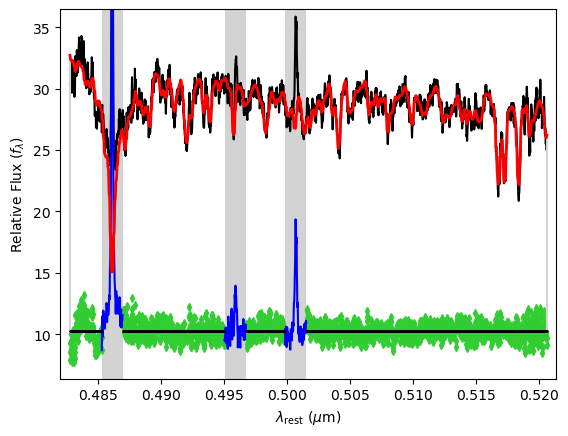

In [85]:
for i in tqdm(range(len(RDB))):
    plot_TF = True if (i == 3) else False
    tmpgalaxy = RDB_spectrum_new[:,i]
    noise = np.full_like(tmpgalaxy,0.1)
    noise = np.ones_like(tmpgalaxy)

    pp = ppxf(sps.templates, tmpgalaxy, noise, velscale_new, [vel_s, vel_dis_s],
                            plot=plot_TF,
                            mask=mask0_new,
                            lam=lam_gal_new, lam_temp=sps.lam_temp,
                            quiet=not plot_TF)
                    # pp_field[i][j]=pp
    Bestfitfield_RDB[:,i]=pp.bestfit

    pp.optimal_template = sps.templates.reshape(sps.templates.shape[0], -1) @ pp.weights
    optimal_templates_RDB[:,i] = pp.optimal_template
    velfield_RDB[i] = pp.sol[0]
    sigfield_RDB[i] = pp.sol[1]
    weights = pp.weights
    indwt = np.where(weights == np.max(weights))[0]
    tempnum_RDB[i] = indwt[0]

## Addtional parameters setting

In [86]:
Index_Wave = pd.DataFrame({
        'Index':['H_beta','Fe_5015','Mg_b','Fe_5270','Fe_5270_s'],
        'BPC_range':[[4827.875,4847.875],[4946.500,4977.750],[5142.625,5161.375],[5233.150,5248.150],[5233.000,5250.000]],
        'CBP_range':[[4847.875,4876.625],[4977.750,5054.000],[5160.125,5192.625],[5245.650,5285.650],[5256.500,5278.500]],
        'RPC_range':[[4876.625,4891.625],[5054.000,5065.250],[5191.375,5206.375],[5285.650,5318.150],[5285.500,5308.000]]
})

In [87]:
Index_use = [0,1,2]

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_19168\1964158015.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


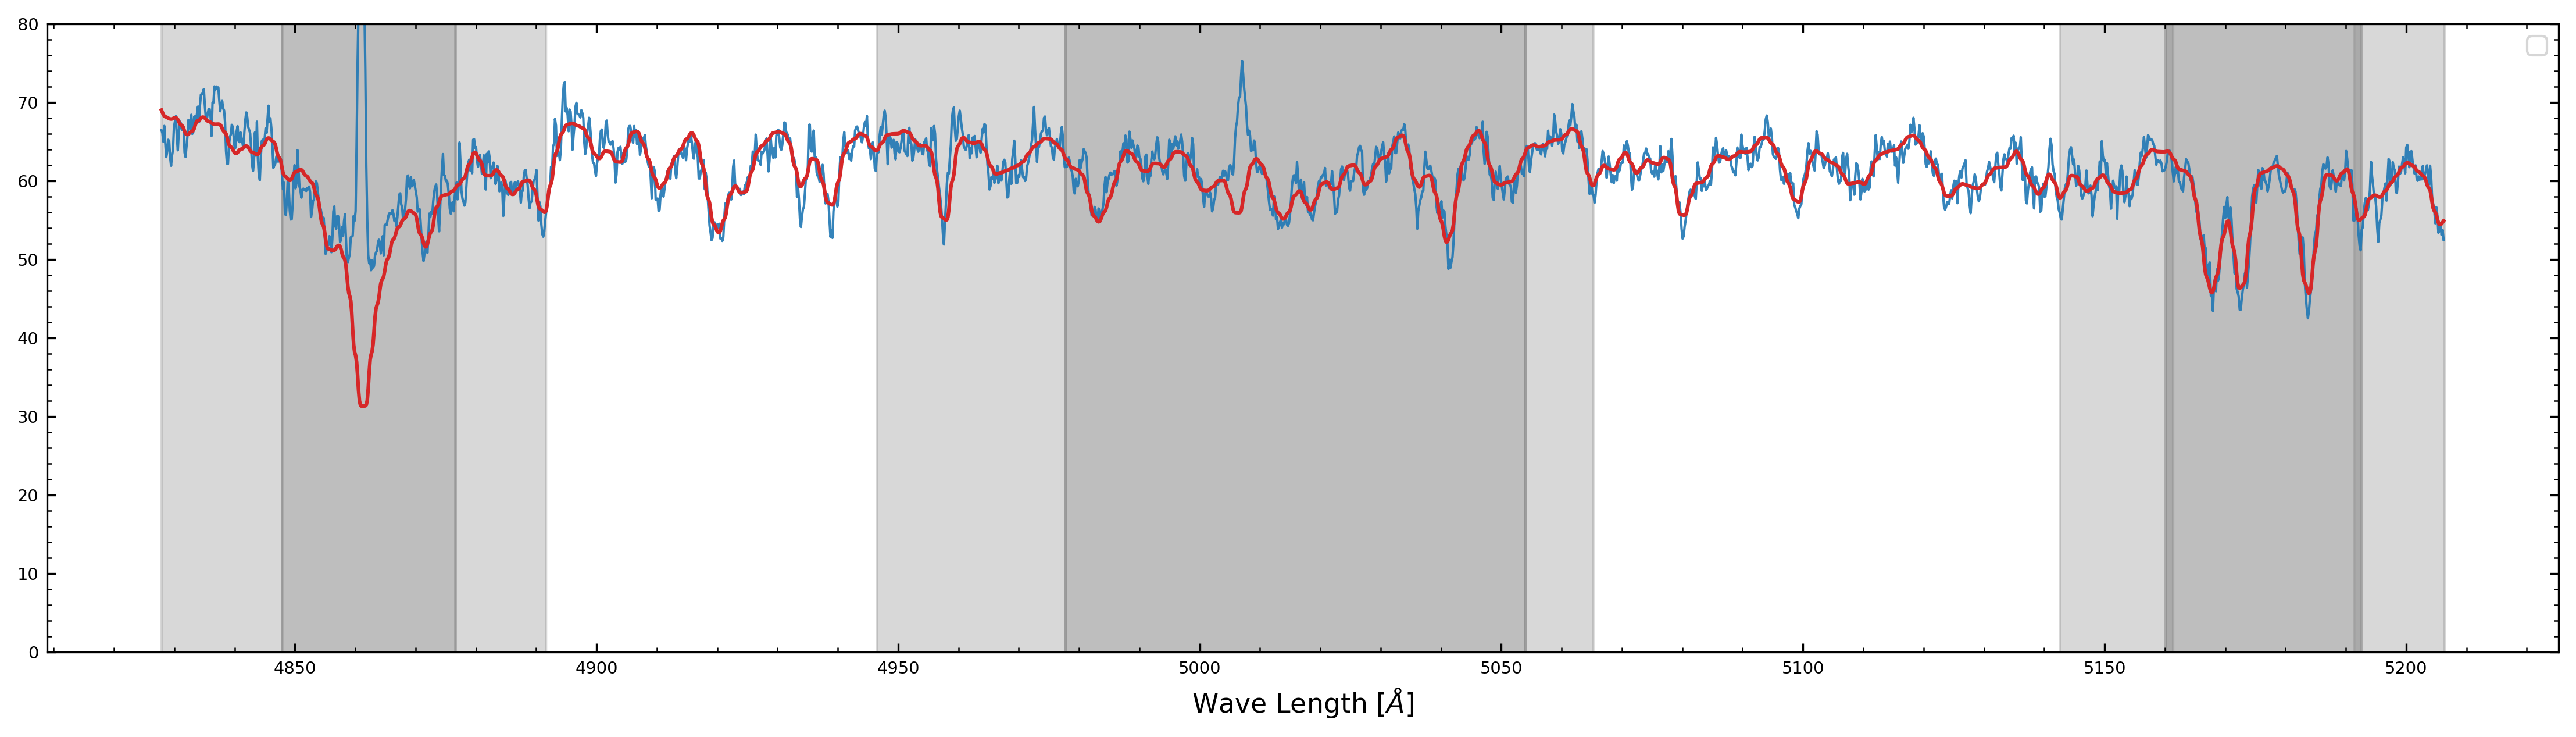

In [88]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal_new,RDB_spectrum_new[:,0], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal_new,Bestfitfield_RDB[:,0], c='tab:red')

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(0,80)
# ax1.set_xlim(0,1)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

## STF

In [89]:
lam_gal = lam_gal_new

### STF parameters setting

In [90]:
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
gas_templates, gas_names, line_wave = util.emission_lines(sps.ln_lam_temp, lam_range_gal, Galaxy_info.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' '[OIII]5007_d']


In [91]:
ngas_comp = 1   # I use three gas kinematic components
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

### Fitting

In [92]:
PP_box = []
for i in tqdm(range(len(RDB))):
        galaxy = RDB_spectrum_new[:,i]
        noise = np.ones_like(galaxy)

        template = optimal_templates_RDB[:,i]
        stars_gas_templates = np.column_stack([template, gas_templates])

        component = [0] + [1]*2
        gas_component=np.array(component) > 0
        moments = [-2, 2]
        ncomp = len(moments)
        tied = [['', ''] for _ in range(ncomp)]

        start = [[velfield_RDB[i], sigfield_RDB[i]],
        [velfield_RDB[i], 50]]
        # start = [[0, 50],
        # [0, 200]]

        vlim = lambda x: velfield_RDB[i] + x*np.array([-100, 100])
        bounds = [[vlim(2), [20, 300]],
                [vlim(2), [20, 100]]]

        pp = ppxf(stars_gas_templates, galaxy, noise, velscale_new, start,
            plot=False,
            moments=moments, degree=8, mdegree=-1,
            component=component, 
            gas_component=gas_component, gas_names=gas_names,
            lam=lam_gal, lam_temp=sps.lam_temp, tied=tied,
            bounds=bounds,
            global_search=True)
        
        PP_box += [pp]

  0%|          | 0/9 [00:00<?, ?it/s]

differential_evolution step 1: f(x)= 8899.81
differential_evolution step 2: f(x)= 7989.5
differential_evolution step 3: f(x)= 7900.86
differential_evolution step 4: f(x)= 7894.98


 11%|█         | 1/9 [00:00<00:03,  2.48it/s]

differential_evolution step 5: f(x)= 7887.91
 Best Fit:       Vel     sigma
 comp.  0:         5        20
 comp.  1:       -17        31
chi2/DOF: 3.456; DOF: 2281; degree = 8; mdegree = 0
Global search - Func calls: 180
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.956       670       175
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      670.5       3.8     -17    31
Comp:  1      [OIII]5007_d_(1)      233.4       4.8     -17    31
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 4976.04
differential_evolution step 2: f(x)= 3579.62
differential_evolution step 3: f(x)= 3213.08
differential_evolution step 4: f(x)= 3047.77
differential_evolution 

 22%|██▏       | 2/9 [00:00<00:03,  2.08it/s]

differential_evolution step 6: f(x)= 2956.59
differential_evolution step 7: f(x)= 2956.59
 Best Fit:       Vel     sigma
 comp.  0:         6        20
 comp.  1:        -4        29
chi2/DOF: 1.295; DOF: 2281; degree = 8; mdegree = 0
Global search - Func calls: 240
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.935       600       113
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      600.4       3.7      -4    29
Comp:  1      [OIII]5007_d_(1)      150.5       4.7      -4    29
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 2032.06
differential_evolution step 2: f(x)= 1797.78
differential_evolution step 3: f(x)= 1797.78
differential_evolution 

 33%|███▎      | 3/9 [00:01<00:02,  2.12it/s]

differential_evolution step 5: f(x)= 1796.14
differential_evolution step 6: f(x)= 1792.12
 Best Fit:       Vel     sigma
 comp.  0:         6        20
 comp.  1:        -0        26
chi2/DOF: 0.7843; DOF: 2281; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.932       420       107
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      420.0       3.6      -0    26
Comp:  1      [OIII]5007_d_(1)      142.0       4.6      -0    26
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1837.92
differential_evolution step 2: f(x)= 1753.3
differential_evolution step 3: f(x)= 1282.27
differential_evolution 

 44%|████▍     | 4/9 [00:01<00:02,  2.06it/s]

differential_evolution step 5: f(x)= 1272.87
differential_evolution step 6: f(x)= 1272.87
differential_evolution step 7: f(x)= 1272.87
 Best Fit:       Vel     sigma
 comp.  0:         6        20
 comp.  1:         3        33
chi2/DOF: 0.5578; DOF: 2281; degree = 8; mdegree = 0
Global search - Func calls: 240
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.931       341      91.2
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      341.2       3.9       3    33
Comp:  1      [OIII]5007_d_(1)      121.3       4.9       3    33
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 982.484
differential_evolution step 2: f(x)= 917.748
differential_evolution

 56%|█████▌    | 5/9 [00:02<00:02,  2.00it/s]

differential_evolution step 5: f(x)= 917.748
differential_evolution step 6: f(x)= 917.748
differential_evolution step 7: f(x)= 915.073
 Best Fit:       Vel     sigma
 comp.  0:         7        20
 comp.  1:        -1        31
chi2/DOF: 0.4010; DOF: 2281; degree = 8; mdegree = 0
Global search - Func calls: 240
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.936       316      66.7
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      315.6       3.8      -1    31
Comp:  1      [OIII]5007_d_(1)      88.69       4.8      -1    31
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 762.112
differential_evolution step 2: f(x)= 684.673
differential_evolution

 67%|██████▋   | 6/9 [00:02<00:01,  2.13it/s]

differential_evolution step 5: f(x)= 638.487
 Best Fit:       Vel     sigma
 comp.  0:         9        20
 comp.  1:         2        42
chi2/DOF: 0.2794; DOF: 2281; degree = 8; mdegree = 0
Global search - Func calls: 180
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.962       235      54.5
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      235.3       4.2       2    42
Comp:  1      [OIII]5007_d_(1)      72.48       5.3       2    42
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 538.52


 78%|███████▊  | 7/9 [00:03<00:00,  2.45it/s]

differential_evolution step 2: f(x)= 538.52
differential_evolution step 3: f(x)= 538.52
 Best Fit:       Vel     sigma
 comp.  0:        14        20
 comp.  1:        14        64
chi2/DOF: 0.2361; DOF: 2281; degree = 8; mdegree = 0
Global search - Func calls: 120
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.01       122      26.1
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      122.4       5.0      14    64
Comp:  1      [OIII]5007_d_(1)      34.78       6.3      14    64
-----------------------------------------------------------------


100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

differential_evolution step 1: f(x)= 668.639
 Best Fit:       Vel     sigma
 comp.  0:        12        20
 comp.  1:        11        67
chi2/DOF: 0.2931; DOF: 2281; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.07      72.5       5.6
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      72.54       5.1      11    67
Comp:  1      [OIII]5007_d_(1)      7.444       6.4      11    67
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 773.408
 Best Fit:       Vel     sigma
 comp.  0:        12        20
 comp.  1:        11        75
chi2/DOF: 0.3390; DOF: 2281; degree = 8; mdegree = 0
Global searc

In [93]:
def CK_SpFT(I_index):
    K_index = I_index

    fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,12), dpi=300, tight_layout=True)
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=.95, bottom=0.65, top=0.95, hspace=0.0)
    ax1 = plt.subplot(gs1[0])

    gs2 = gridspec.GridSpec(1, 1)
    gs2.update(left=0.05, right=.95, bottom=0.35, top=0.65, hspace=0.0)
    ax2 = plt.subplot(gs2[0])

    gs3 = gridspec.GridSpec(1, 1)
    gs3.update(left=0.05, right=.95, bottom=0.05, top=0.35, hspace=0.0)
    ax3 = plt.subplot(gs3[0])


# -------------------------------------------------------------------------------------------------------------------------------------

    ax1.plot(lam_gal,RDB_spectrum_new[:,I_index], c='tab:blue', lw=1, alpha=.9, label=galaxy_name+'\npixel:[{:}]'.format(I_index))
    ax1.plot(lam_gal,Bestfitfield_RDB[:,I_index], '--', c='tab:red', alpha=.9)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'CBP_range'][0]
        RHS = Index_Wave.loc[i,'CBP_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'BPC_range'][0]
        RHS = Index_Wave.loc[i,'BPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
    for i in Index_use:
        LHS = Index_Wave.loc[i,'RPC_range'][0]
        RHS = Index_Wave.loc[i,'RPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)

    for i in [0]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 1, alpha=.9)

    for i in [1]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 1, alpha=.9)

    ax1.plot(lam_gal,PP_box[K_index].bestfit, '-', lw=.7, c='tab:red')


# -------------------------------------------------------------------------------------------------------------------------------------

    ax2.plot(lam_gal, np.zeros(lam_gal.shape), '-', color='k', lw=.7, alpha=.9, zorder = 0)
    ax2.plot(lam_gal, [np.median(RDB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)]*lam_gal.shape[0], '--', color='tab:blue', lw=1, alpha=.9, zorder = 1)
    MPSig = np.median(RDB_spectrum_new[:,I_index]-PP_box[K_index].bestfit) + np.std(RDB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)
    MMSig = np.median(RDB_spectrum_new[:,I_index]-PP_box[K_index].bestfit) - np.std(RDB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)
    ax2.fill([min(lam_gal), max(lam_gal), max(lam_gal), min(lam_gal)], [MPSig, MPSig, MMSig, MMSig], color='tab:gray', alpha=.2,
             label=r'Range:{:1.3f}$\pm${:1.3f}'.format(np.median(RDB_spectrum_new[:,I_index]-PP_box[K_index].bestfit), np.std(RDB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)), zorder=1)
    ax2.plot(lam_gal, RDB_spectrum_new[:,I_index]-PP_box[K_index].bestfit, '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)

# -------------------------------------------------------------------------------------------------------------------------------------

    ax3.plot(lam_gal, RDB_spectrum_new[:,I_index]-Bestfitfield_RDB[:,I_index], '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)
    for i in [0]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 2, alpha=.9)
    for i in [1]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 2, alpha=.9)
    
    ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,0]+PP_box[K_index].gas_bestfit_templates[:,1, ], lw=.7, color='tab:red', zorder = 2, alpha=.9)


# -------------------------------------------------------------------------------------------------------------------------------------


    ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    

    ax1.set_xlim(min(lam_gal), max(lam_gal))
    ax2.set_xlim(min(lam_gal), max(lam_gal))
    ax3.set_xlim(min(lam_gal), max(lam_gal))
    ax1.set_ylim(0,max(RDB_spectrum_new[:,I_index])*1.1)
    ax2.set_ylim(min(RDB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)*1.2, max(RDB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)*1.2)
    ax3.set_ylim(min(RDB_spectrum_new[:,I_index]-Bestfitfield_RDB[:,I_index])*1.2, max(RDB_spectrum_new[:,I_index]-Bestfitfield_RDB[:,I_index])*1.2)

    ax3.set_xlabel(r'Wave Length $[\AA]$', size=11)
    
    ax1.legend()
    ax2.legend()
    # ax3.legend()
    plt.show()
    plt.savefig('./../../FitPlot/Fit_06[24Dec06][VCC1588RDBFit]/RDB_res/'+galaxy_name+'Fig[{:}].pdf'.format(K_index), format='pdf', bbox_inches='tight')
    plt.clf()
    plt.close()

    PP_box[K_index] = []

In [94]:
# for i in range(len(RDB)):
#     CK_SpFT(i)

# Data collect

## Spectrum Index

In [95]:
H_Beta_map = np.ndarray(shape=len(RDB))
Fe_5015_map = np.ndarray(shape=len(RDB))
Mg_b_map = np.ndarray(shape=len(RDB))

In [96]:
LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])

In [97]:
x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))

In [98]:
for i in range(len(RDB)):
        
        K_index = i
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]

        LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])
        LCB = Index_Wave.loc[0,'CBP_range'][0]
        RCB = Index_Wave.loc[0,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i] - y_spectrum[:,i]
        for k in range(len(y_SL[:,i])):
            NS[k] = NS[k]/y_SL[k,i]

        H_Beta_map[i] = np.trapz(NS, x_wave[:,i])

In [99]:
#Fe 5015

LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])

In [100]:
#Fe 5015

x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))

In [101]:
#Fe 5015

for i in range(len(RDB)):
        
        K_index = i
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]

        LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])
        LCB = Index_Wave.loc[1,'CBP_range'][0]
        RCB = Index_Wave.loc[1,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i] - y_spectrum[:,i]
        for k in range(len(y_SL[:,i])):
            NS[k] = NS[k]/y_SL[k,i]

        Fe_5015_map[i] = np.trapz(NS, x_wave[:,i])

In [102]:
#Mg b

LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])

In [103]:
#Mg b

x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))

In [104]:
#Mg b

for i in range(len(RDB)):
        
        K_index = i
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]


        LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])
        LCB = Index_Wave.loc[2,'CBP_range'][0]
        RCB = Index_Wave.loc[2,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i] - y_spectrum[:,i]
        for k in range(len(y_SL[:,i])):
            NS[k] = NS[k]/y_SL[k,i]

        Mg_b_map[i] = np.trapz(NS, x_wave[:,i])

## OTP

In [105]:
names = ['Hbeta', '[OIII]5007_d']
c_kms = 299792.458  # speed of light in km/s

In [106]:
VNB_Sol = pd.DataFrame({'H_beta_EL_value':[],'H_beta_EL_ANR':[],
                        'O_3_5007_EL_value':[],'O_3_5007_EL_ANR':[],
                        'Component_Sol':[],
                        'H_beta_SI':[],'Mg_b_SI':[],'Fe_5015_SI':[],
                        'R':[],'SNR':[],'Signal':[],'Noise':[],
                        'K_index':[]})

In [107]:
for Index_num in range(len(RDB)):
    K_index = RDB[Index_num][0]

    dx = []
    dy = []
    dr = []

    for k_index in K_index:
        i = int(k_index/max(Galaxy_info.col))
        j = k_index%max(Galaxy_info.col)

        Ori_ra  = Galaxy_info.CRVAL1 + ((i)*Galaxy_info.CD1_2) + ((j)*Galaxy_info.CD1_1) + (Galaxy_info.CD1_2+Galaxy_info.CD1_1)/2
        Ori_dec = Galaxy_info.CRVAL2 + ((i)*Galaxy_info.CD2_2) + ((j)*Galaxy_info.CD2_1) + (Galaxy_info.CD2_2+Galaxy_info.CD2_1)/2
        O_x = (Galaxy_info.CRVAL1 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD1_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD1_1))/2)
        O_y = (Galaxy_info.CRVAL2 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD2_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD2_1))/2)
        dx += [Ori_ra - O_x]
        dy += [Ori_dec - O_y]
        dr += [np.sqrt((Ori_ra - O_x)**2 + (Ori_dec - O_y)**2)]
    R = np.mean(dr)

    rms = robust_sigma(RDB_spectrum_new[:,Index_num] - PP_box[Index_num].bestfit, zero=1)
    for p, name in enumerate(names):
        kk = gas_names == name + '_(1)'   # Extract first gas kinematic component
        dlam = line_wave[kk]*Galaxy_info.velscale/c_kms   # Angstrom per pixel at line wavelength (dlam/lam = dv/c)
        flux = (PP_box[Index_num].gas_flux[kk]*dlam)[0]  # Convert to ergs/(cm^2 s)
        an = np.max(PP_box[Index_num].gas_bestfit_templates[:, kk])/rms
        if(kk[0]):
            H_Beta_EL = flux
            H_Beta_EL_AN = an
        if(kk[1]):
            O_5007_EL = flux
            O_5007_EL_AN = an

    S_val = np.mean(RDB_spectrum_new[:,Index_num][ np.where((lam_gal>5075) & (lam_gal<5125)) ]/PP_box[Index_num].bestfit[ np.where((lam_gal>5075) & (lam_gal<5125)) ])
    N_val = np.std(RDB_spectrum_new[:,Index_num][ np.where((lam_gal>5075) & (lam_gal<5125)) ]/PP_box[Index_num].bestfit[ np.where((lam_gal>5075) & (lam_gal<5125)) ])


    VNB_Sol_lim = pd.DataFrame({'H_beta_EL_value':[H_Beta_EL],'H_beta_EL_ANR':[H_Beta_EL_AN],
                        'O_3_5007_EL_value':[O_5007_EL],'O_3_5007_EL_ANR':[O_5007_EL_AN],
                        'Component_Sol':[PP_box[Index_num].sol],
                        'H_beta_SI':[H_Beta_map[Index_num]],'Mg_b_SI':[Fe_5015_map[Index_num]],'Fe_5015_SI':[Mg_b_map[Index_num]],
                        'R':[R],'SNR':[S_val/N_val],'Signal':[S_val],'Noise':[N_val],'K_index':[K_index]})
    VNB_Sol = TB_reindex(pd.concat([VNB_Sol, VNB_Sol_lim]))

In [108]:
VNB_Sol.to_csv('./../FitData/Fit_DS_07[24Dec07][VCC1588]/'+galaxy_name+'_RDB_SFR.csv')